In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from math import cos, sin, pi

In [2]:
# это мой метод генерации точек
# кластеры которые тут упоминаются это чисто только для красивой генерации
def generate_points(cluster_count=10,
                    max_x=100,
                    max_y=100,
                    point_count=20,
                    spread=7):
    points = []
    for i in range(cluster_count):
        cluster_x = random.randint(0, max_x)
        cluster_y = random.randint(0, max_y)

        for i in range(point_count):
            point_x = random.randint(cluster_x - spread, cluster_x + spread)
            point_y = random.randint(cluster_y - spread, cluster_y + spread)

            points.append(np.array([point_x, point_y]))

    return points

In [3]:
def render_points(points, s=10):
    plt.scatter(*np.transpose(points), s=s)
    plt.gca().set_aspect('equal')

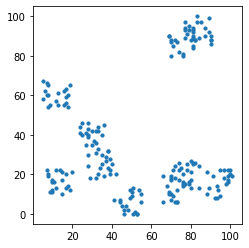

In [4]:
_points = generate_points()
render_points(_points)

In [5]:
def find_points_center(points):
    return sum(points) / len(points)

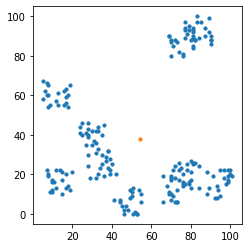

In [6]:
_center = find_points_center(_points)
render_points(_points)
render_points([_center])

In [7]:
def dist(point1, point2):
    return np.linalg.norm(point1 - point2)

In [8]:
def find_farthest_point_from_center(points, center_point):
    return max([(dist(center_point, x), x) for x in points], key=lambda x: x[0])[1]

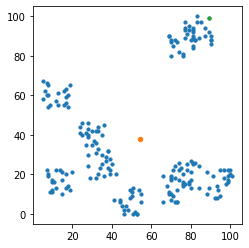

In [9]:
_farthest_point = find_farthest_point_from_center(_points, _center)
render_points(_points)
render_points([_center], s=20)
render_points([_farthest_point], s=10)

In [10]:
def render_circle(center, radius, color='g'):
    circle1 = plt.Circle(tuple(np.transpose(center)), radius, fill=False)
    plt.gca().add_patch(circle1)
    plt.gca().set_aspect('equal')

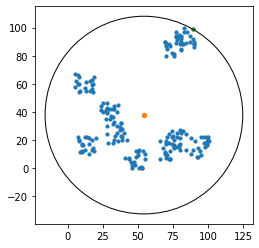

In [11]:
render_points(_points)
render_points([_center], s=20)
render_points([_farthest_point], s=10)
render_circle(_center, dist(_center, _farthest_point))

In [12]:
def calc_raw_centroids(center, radius, count):
    centroids = []
    for i in range(count):
        raw_x = cos(2 * pi / count * i)
        raw_y = sin(2 * pi / count * i)
        centroids.append(center + radius * np.array([raw_x, raw_y]))
    return centroids

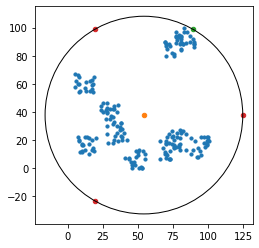

In [13]:
k = 3

_centroids = calc_raw_centroids(_center, dist(_center, _farthest_point), k)

render_points(_points)
render_points([_center], s=20)
render_points([_farthest_point], s=20)
render_circle(_center, dist(_center, _farthest_point))
render_points(_centroids, s=20)

In [14]:
def generate_cluster_matrix(points, centroids, m = 2, debug=False):
    matrix = np.zeros(shape=(len(centroids), len(points)))
    for point_index, point  in enumerate(points):
        for centroid_index, centroid in enumerate(centroids):
            power = 2 / (m - 1)
            current_dist = dist(point, centroid)
            # temp_sum = 0
            # for temp_centroid in centroids:
            #     temp_sum += (1 / dist(point, temp_centroid)) ** power
            temp_sum = sum([(1 / dist(point, temp_centroid)) ** power for temp_centroid in centroids])

            probability = ((1 / current_dist) ** power) / temp_sum
            matrix[centroid_index][point_index] = probability

    if debug:
        render_matrix(matrix, centroids, points)
        plt.show()

    return matrix

In [15]:
_matrix = generate_cluster_matrix(_points, _centroids)

складываем первый столбец, сумма должна быть 1:

In [16]:
print(sum([x for x in _matrix.transpose()[0]]))

1.0


In [17]:
def render_matrix(matrix, centroids, points):
    color_count = len(matrix)
    color_map = plt.cm.get_cmap('hsv', color_count + 1)
    colors = [color_map(x) for x in range(color_count)]

    temp_matrix = matrix.transpose()

    plt.gca().set_aspect('equal')
    for point_index, point in enumerate(points):
        cluster_index = max([x for x in enumerate(temp_matrix[point_index])], key=lambda x: x[1])[0]
        plt.scatter(*point, s=10, color=colors[cluster_index])

    for centroid_index, centroid in enumerate(centroids):
        plt.scatter(*centroid, s=50, color='black')
        plt.scatter(*centroid, s=20, color=colors[centroid_index])

    # for centroid_index, point_probabilities in enumerate(matrix):
    #     centroid = centroids[centroid_index]
    #     plt.scatter(*centroid)
    #
    #     for point_index, point_probability in enumerate(point_probabilities):
    #         point = points[point_index]
    #         plt.plot(
    #             *np.array([point, centroid]).transpose(),
    #             color=colors[centroid_index],
    #             alpha=point_probability
    #         )
    # plt.show()

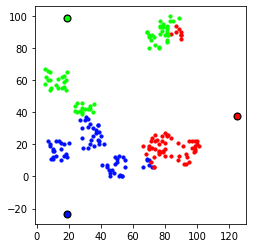

In [18]:
render_matrix(_matrix, _centroids, _points)

In [19]:
def recalculate_new_centroid_positions(matrix, centroids, points):
    for centroid_index, centroid in enumerate(centroids):
        sum_2d = np.zeros(2)
        for point_index, point in enumerate(points):
            sum_2d += point * matrix[centroid_index][point_index]
        count = sum(matrix[centroid_index])

        np.copyto(centroid, sum_2d / count)


In [20]:
recalculate_new_centroid_positions(_matrix, _centroids, _points)

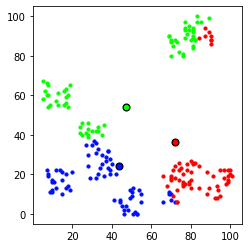

In [21]:
render_matrix(_matrix, _centroids, _points)

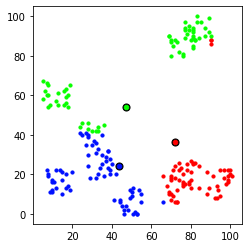

In [22]:
# def recalculate_matrix(matrix, centroids, points):
#     new_matrix = np.zeros(shape=(len(centroids), len(points)))

_new_matrix = generate_cluster_matrix(_points, _centroids)

render_matrix(_new_matrix, _centroids, _points)

In [23]:
_diff_matrix = abs(_matrix - _new_matrix)

In [24]:
# def cluster_by_c_means(eps=0.01):
#
#     points = generate_points()
#
#
#     counter = 0
#     while (_diff_matrix > eps).all():
#         recalculate_new_centroid_positions(_matrix, _centroids, _points)
#         _new_matrix = generate_cluster_matrix(_points, _centroids)
#         _diff_matrix = abs(_matrix - _new_matrix)
#         _matrix = _new_matrix
#         counter+=1
#         if counter >= 1000:
#             print('stop!')
#             return

In [25]:
eps = 0.01
counter = 0
while (_diff_matrix > eps).any():
    recalculate_new_centroid_positions(_matrix, _centroids, _points)
    _new_matrix = generate_cluster_matrix(_points, _centroids)
    _diff_matrix = abs(_matrix - _new_matrix)
    _matrix = _new_matrix
    counter+=1
    if counter >= 1000:
        print('stop!')
        break

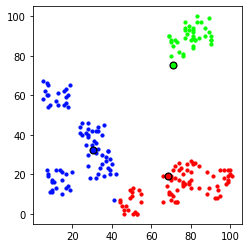

In [26]:
render_matrix(_matrix, _centroids, _points)

In [27]:
def cluster_by_c_means(k=6, eps=0.01, m=2, debug=False):
    points = generate_points(
        cluster_count=k, # генерирую столько кластеров, сколько хочу найти
        max_x=200,
        max_y=200,
        spread=10
    )

    if debug:
        render_points(points)
        plt.show()

    center = find_points_center(points)
    farthest_point = find_farthest_point_from_center(points, center)
    centroids = calc_raw_centroids(center, dist(center, farthest_point), k)
    matrix = generate_cluster_matrix(points, centroids, m=m, debug=debug)
    diff_matrix = np.full(np.shape(matrix), 1)

    cnt = 0
    while (diff_matrix > eps).any():
        recalculate_new_centroid_positions(matrix, centroids, points)
        new_matrix = generate_cluster_matrix(points, centroids, m=m, debug=debug)
        diff_matrix = abs(matrix - new_matrix)
        matrix = new_matrix
        cnt+=1
        if cnt >= 1000:
            print('stop!')
            break
    render_matrix(matrix, centroids, points)

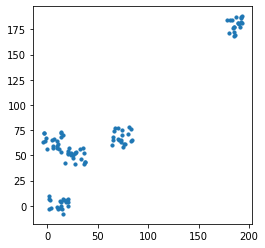

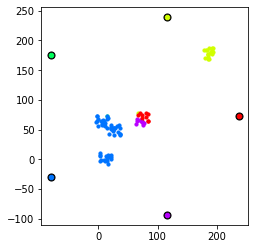

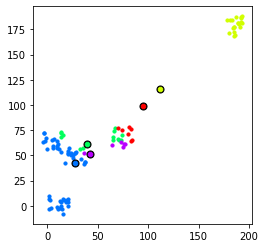

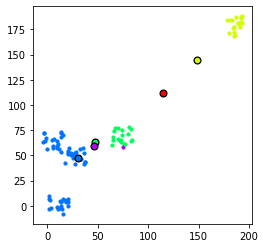

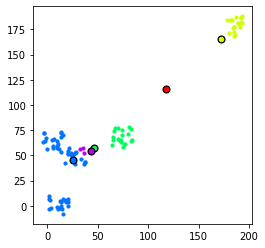

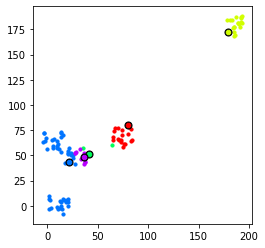

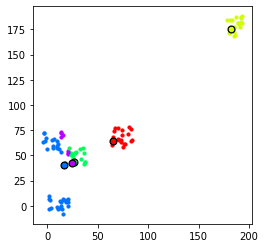

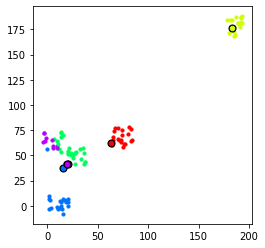

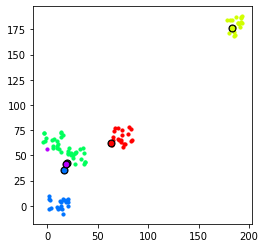

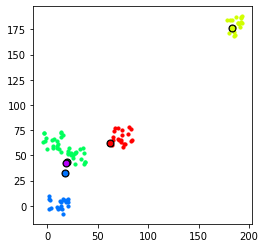

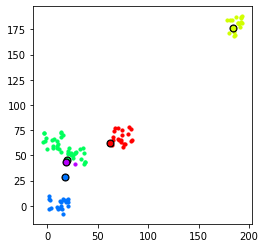

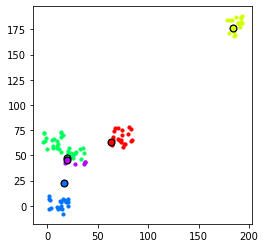

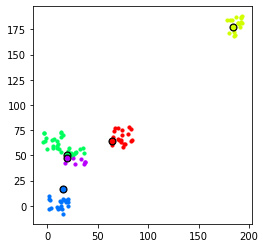

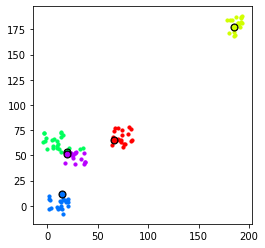

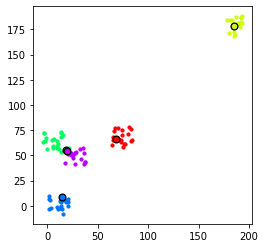

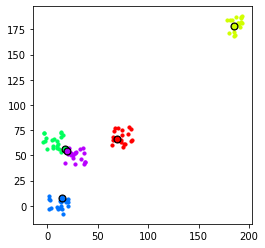

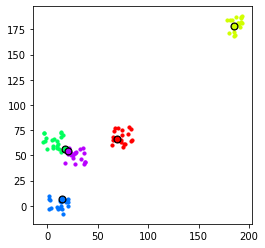

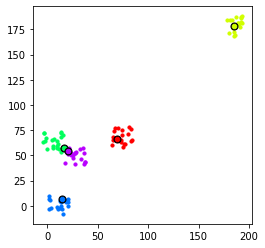

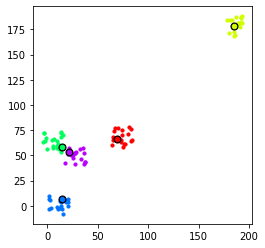

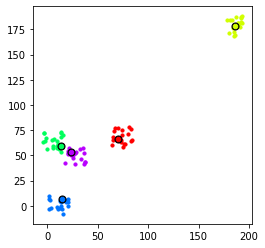

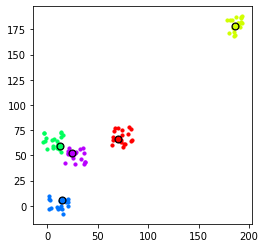

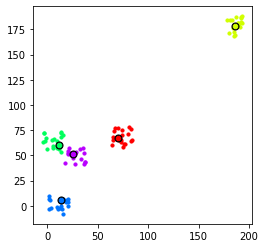

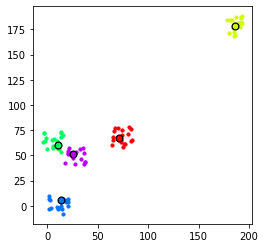

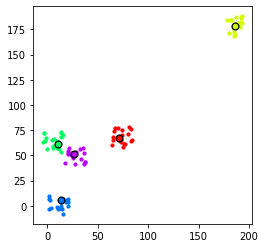

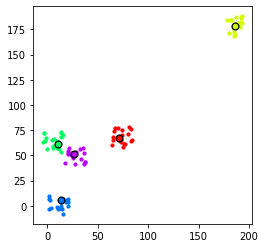

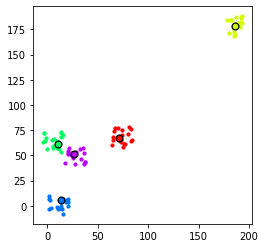

In [28]:
cluster_by_c_means(k=5, debug=True)